## Where do embeddings come from?
### Embedding MNIST images and NLP sentences into vectors.


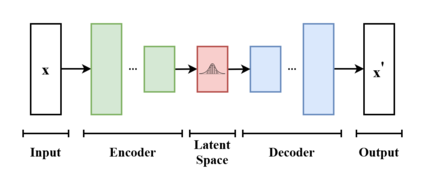

[Source](https://en.wikipedia.org/wiki/Variational_autoencoder)

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from scipy.stats import norm

In [6]:
# Load data – training and test
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()

In [7]:
#Normalize and Reshape images (flatten)
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr_flat, x_te_flat = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)

In [8]:
print(x_tr.shape, x_te.shape)
print(x_tr_flat.shape, x_te_flat.shape)

(60000, 28, 28) (10000, 28, 28)
(60000, 784) (10000, 784)


In [9]:
# Neural Network Parameters
batch_size, n_epoch = 100, 50
n_hidden, z_dim = 256, 2

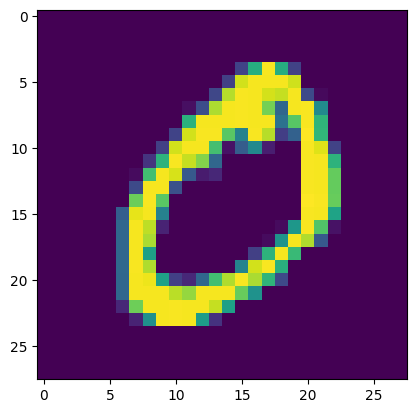

In [10]:
# Example of a training image
plt.imshow(x_tr[1]);

In [11]:
# sampling function
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var) * eps

In [12]:
# Encoder - from 784->256->128->2
inputs_flat = Input(shape=(x_tr_flat.shape[1:]))
x_flat = Dense(n_hidden, activation='relu')(inputs_flat) # first hidden layer
x_flat = Dense(n_hidden//2, activation='relu')(x_flat)  # second hidden layer

# hidden state, which we will pass into the Model to get the Encoder.
mu_flat = Dense(z_dim)(x_flat)
log_var_flat = Dense(z_dim)(x_flat)
z_flat = Lambda(sampling, output_shape=(z_dim,))([mu_flat, log_var_flat])

In [13]:
#Decoder - from 2->128->256->784
latent_inputs = Input(shape=(z_dim,))
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_tr_flat.shape[1], activation='sigmoid')
z_decoded = z_decoder1(latent_inputs)
z_decoded = z_decoder2(z_decoded)
y_decoded = y_decoder(z_decoded)
decoder_flat = Model(latent_inputs, y_decoded, name="decoder_conv")

outputs_flat = decoder_flat(z_flat)

In [14]:
# variational autoencoder (VAE) - to reconstruction input
reconstruction_loss = losses.binary_crossentropy(inputs_flat,
                                                 outputs_flat) * x_tr_flat.shape[1]
kl_loss = 0.5 * K.sum(K.square(mu_flat) + K.exp(log_var_flat) - log_var_flat - 1, axis = -1)
vae_flat_loss = reconstruction_loss + kl_loss

# Build model
#  Ensure that the reconstructed outputs are as close to the inputs
vae_flat = Model(inputs_flat, outputs_flat)
vae_flat.add_loss(vae_flat_loss)
vae_flat.compile(optimizer='adam')

In [15]:
# train
vae_flat.fit(
    x_tr_flat,
    shuffle=True,
    epochs=n_epoch,
    batch_size=batch_size,
    validation_data=(x_te_flat, None),
    verbose=1
)

Epoch 1/50
600/600 [==============================] - 6s 7ms/step - loss: 201.1788 - val_loss: 173.7644
Epoch 2/50
600/600 [==============================] - 4s 7ms/step - loss: 166.8122 - val_loss: 161.7173
Epoch 3/50
600/600 [==============================] - 4s 7ms/step - loss: 158.7951 - val_loss: 155.2078
Epoch 4/50
600/600 [==============================] - 5s 8ms/step - loss: 154.2400 - val_loss: 152.3432
Epoch 5/50
600/600 [==============================] - 5s 8ms/step - loss: 151.6455 - val_loss: 149.9945
Epoch 6/50
600/600 [==============================] - 5s 8ms/step - loss: 150.1386 - val_loss: 149.4218
Epoch 7/50
600/600 [==============================] - 5s 8ms/step - loss: 148.4127 - val_loss: 147.3153
Epoch 8/50
600/600 [==============================] - 5s 8ms/step - loss: 147.1432 - val_loss: 146.3746
Epoch 9/50
600/600 [==============================] - 5s 8ms/step - loss: 145.8761 - val_loss: 145.1387
Epoch 10/50
600/600 [==============================] - 5s 8ms/st

### Visualize Embeddings

In [16]:
# Build encoders
encoder_f = Model(inputs_flat, z_flat)  # flat encoder

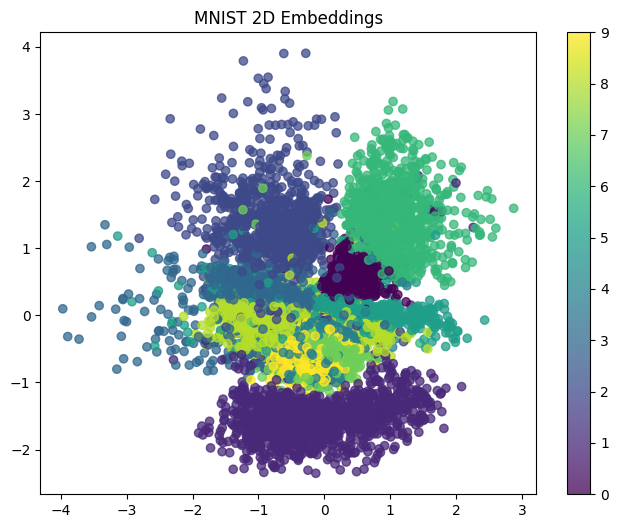

In [17]:
# Plot of the digit classes in the latent space
x_te_latent = encoder_f.predict(x_te_flat, batch_size=batch_size,verbose=0)
plt.figure(figsize=(8, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_te, alpha=0.75)
plt.title('MNIST 2D Embeddings')
plt.colorbar()
plt.show()

In [20]:
encoder_f.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 dense_4 (Dense)             (None, 256)                  200960    ['input_2[0][0]']             
                                                                                                  
 dense_5 (Dense)             (None, 128)                  32896     ['dense_4[0][0]']             
                                                                                                  
 dense_6 (Dense)             (None, 2)                    258       ['dense_5[0][0]']             
                                                                                            

## Example: compare three embeddings

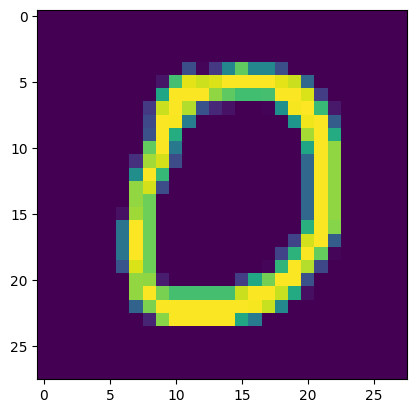

In [19]:
plt.imshow(x_te_flat[10].reshape(28,28));

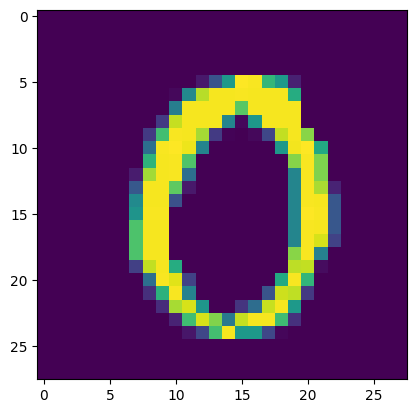

In [20]:
plt.imshow(x_te_flat[13].reshape(28,28));

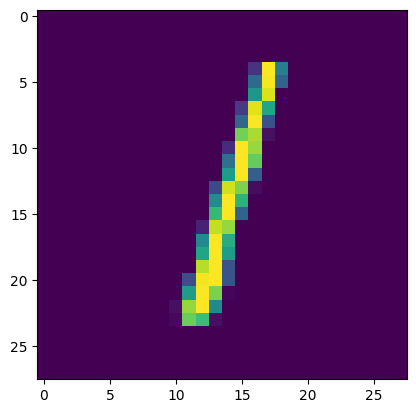

In [21]:
plt.imshow(x_te_flat[2].reshape(28,28));

In [22]:
# calculate vectors for each digit
zero_A = x_te_latent[10]
zero_B = x_te_latent[13]
one = x_te_latent[2]

print(f"Embedding for the first ZERO is  {zero_A}")
print(f"Embedding for the second ZERO is {zero_B}")
print(f"Embedding for the ONE is         {one}")

Embedding for the first ZERO is  [0.1606547 0.3989213]
Embedding for the second ZERO is [0.13972294 0.32344702]
Embedding for the ONE is         [ 0.05938664 -1.7690324 ]


## Using more advanced models based on the Transformer architechture you can embed sentences aswell.

In [24]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

c:\Users\Hassan.Ali\AppData\Local\anaconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
1_Pooling/config.json: 100%|██████████| 190/190 [00:00<?, ?B/s] 
README.md: 100%|██████████| 3.69k/3.69k [00:00<?, ?B/s]
config_sentence_transformers.json: 100%|██████████| 122/122 [00:00<?, ?B/s] 
pytorch_model.bin: 100%|██████████| 90.9M/90.9M [01:30<00:00, 1.01MB/s]
sentence_bert_config.json: 100%|██████████| 53.0/53.0 [00:00<?, ?B/s]
special_tokens_map.json: 100%|██████████| 112/112 [00:00<?, ?B/s] 
tokenizer.json: 100%|██████████| 466k/466k [00:00<00:00, 1.11MB/s]
tokenizer_config.json: 100%|██████████| 314/314 [00:00<?, ?B/s] 
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 1.52MB/s]
modules.json: 100%|██████████| 229/229 [00:00<?, ?B/s] 


In [27]:
#Sentences we want to encode. Example:
sentence = ['The team enjoyed the hike through the meadow',
            'The national park had great views',
            'Olive oil drizzled over pizza tastes delicious']

In [28]:
#Sentences are encoded by calling model.encode()
embedding = model.encode(sentence)

#Preview the embeddings
print(embedding)

[[ 0.37061912  0.26414263  0.21265689 ...  0.14994572 -0.25794926
  -0.23970763]
 [ 0.669333    0.40094957 -0.4820839  ...  0.10645875 -1.5067166
  -0.01547365]
 [-0.26555923  0.11172395 -0.14733042 ...  0.42197487  0.88394636
   0.10763877]]


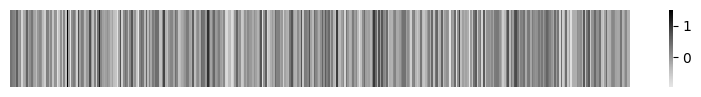

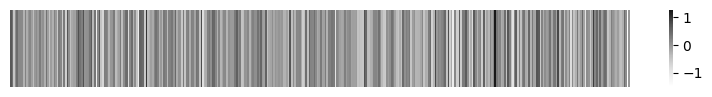

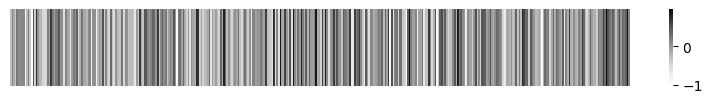

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(embedding[0].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(embedding[1].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(embedding[2].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

(array([13., 32., 64., 99., 87., 54., 25.,  7.,  2.,  1.]),
 array([-0.94479835, -0.70075464, -0.45671096, -0.21266726,  0.03137643,
         0.27542013,  0.51946384,  0.76350754,  1.00755119,  1.2515949 ,
         1.49563861]),
 <BarContainer object of 10 artists>)

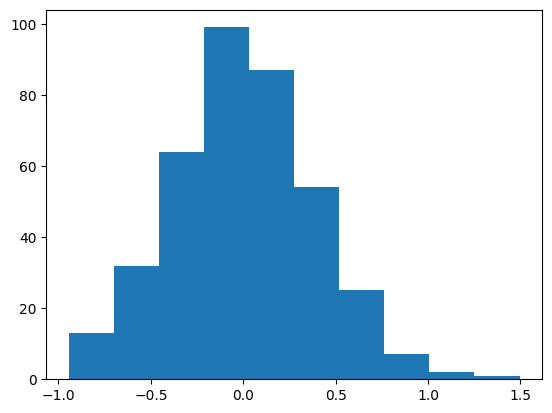

In [74]:
plt.hist(embedding[0])

## How can we measure the distance between these Image and Sentence Embeddings?

There are many ways to calculate the distances between two vectors.

Here we will cover 4 distance metrics that you might find being used in the context of vector databases:
- Euclidean Distance(L2)
- Manhattan Distance(L1)
- Dot Product
- Cosine Distance

### Euclidean Distance(L2)
The length of the shortest path between two points or vectors.

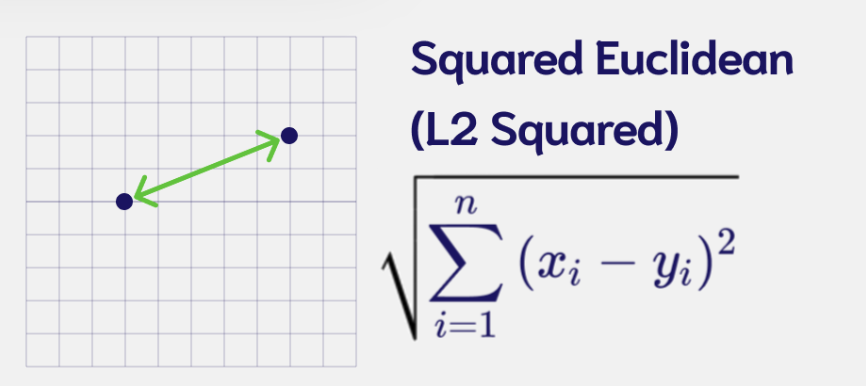

In [59]:
# Euclidean Distance
L2 = [(zero_A[i] - zero_B[i])**2 for i in range(len(zero_A))]
L2 = np.sqrt(np.array(L2).sum())
print(L2)

0.07832309327024589


In [60]:
#An alternative way of doing this
np.linalg.norm((zero_A - zero_B), ord=2)

0.078323096

In [77]:
# andother one line method :JOY:
np.sqrt(np.sum((zero_A-zero_B)**2))

0.078323096

In [78]:
#Calculate L2 distances
print("Distance zeroA-zeroB:", np.linalg.norm((zero_A - zero_B), ord=2))
print("Distance zeroA-one:  ", np.linalg.norm((zero_A - one), ord=2))
print("Distance zeroB-one:  ", np.linalg.norm((zero_B - one), ord=2))

Distance zeroA-zeroB: 0.078323096
Distance zeroA-one:   2.1703176
Distance zeroB-one:   2.094021


### Manhattan Distance(L1)
Distance between two points if one was constrained to move only along one axis at a time.

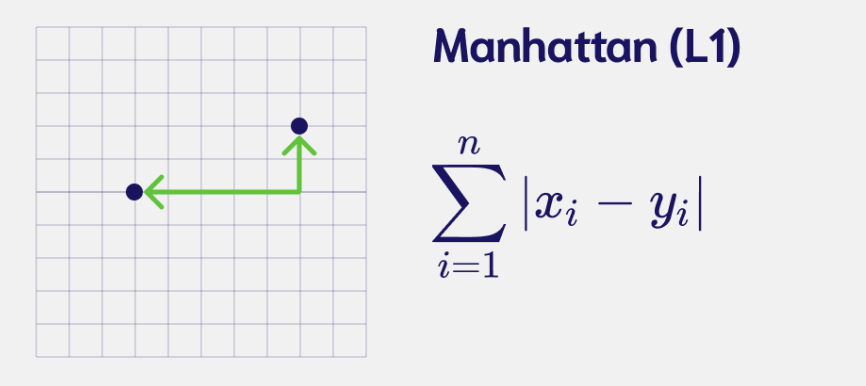

In [79]:
#Another oneline method
np.sum(np.abs((zero_A-zero_B)))

0.09640604

In [62]:
# Manhattan Distance
L1 = [zero_A[i] - zero_B[i] for i in range(len(zero_A))]
L1 = np.abs(L1).sum()

print(L1)

0.09640604


In [63]:
#an alternative way of doing this is
np.linalg.norm((zero_A - zero_B), ord=1)

0.09640604

In [80]:
#Calculate L1 distances
print("Distance zeroA-zeroB:", np.linalg.norm((zero_A - zero_B), ord=1))
print("Distance zeroA-one:  ", np.linalg.norm((zero_A - one), ord=1))
print("Distance zeroB-one:  ", np.linalg.norm((zero_B - one), ord=1))

Distance zeroA-zeroB: 0.09640604
Distance zeroA-one:   2.2692218
Distance zeroB-one:   2.1728158


### Dot Product
Measures the magnitude of the projection of one vector onto the other.

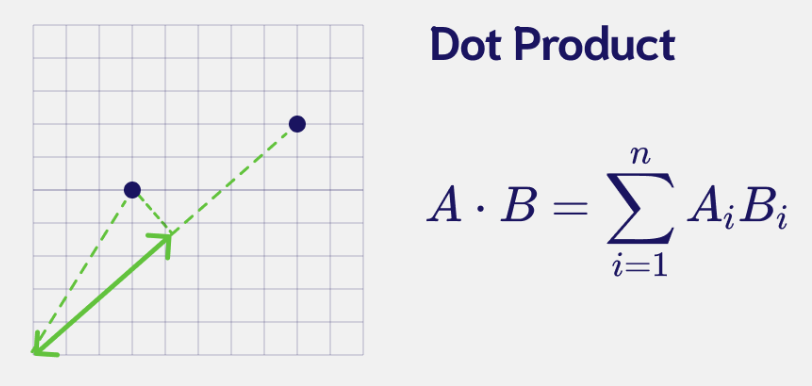

In [65]:
# Dot Product
np.dot(zero_A,zero_B)

0.15147707

In [66]:
#Calculate Dot products
print("Distance zeroA-zeroB:", np.dot(zero_A, zero_B))
print("Distance zeroA-one:  ", np.dot(zero_A, one))
print("Distance zeroB-one:  ", np.dot(zero_B, one))

Distance zeroA-zeroB: 0.15147707
Distance zeroA-one:   -0.69616395
Distance zeroB-one:   -0.5638906


### Cosine Distance
Measure the difference in directionality between vectors.

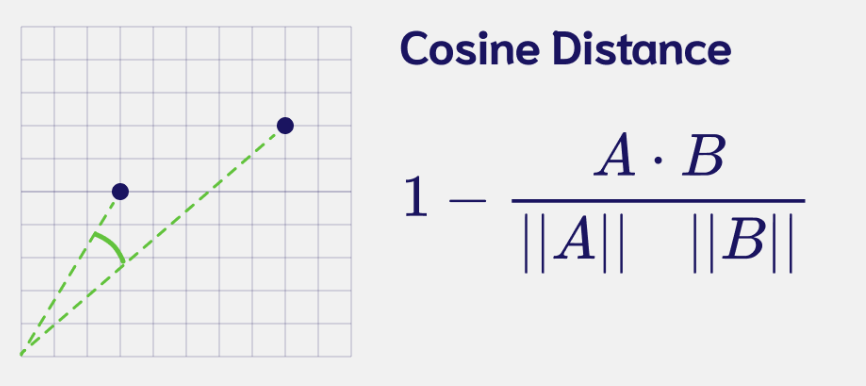

In [81]:
# Cosine Distance
cosine = 1 - np.dot(zero_A,zero_B)/(np.linalg.norm(zero_A)*np.linalg.norm(zero_B))
print(f"{cosine:.6f}")

0.000310


In [82]:
zero_A/zero_B

array([1.149809 , 1.2333436], dtype=float32)

In [69]:
# Cosine Distance function
def cosine_distance(vec1,vec2):
  cosine = 1 - (np.dot(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2)))
  return cosine

In [83]:
#Cosine Distance
print(f"Distance zeroA-zeroB: {cosine_distance(zero_A, zero_B): .6f}")
print(f"Distance zeroA-one:   {cosine_distance(zero_A, one): .6f}")
print(f"Distance zeroB-one:   {cosine_distance(zero_B, one): .6f}")

Distance zeroA-zeroB:  0.000310
Distance zeroA-one:    1.914547
Distance zeroB-one:    1.904186


## Now with the sentence embeddings!

Dot Product and Cosine Distance are commonly used in the field of NLP, to evaluate how similar two sentence embeddings are.
So here we will only use those two.

- embedding0 - 'The team enjoyed the hike through the meadow'

- embedding1 - The national park had great views'

- embedding2 - 'Olive oil drizzled over pizza tastes delicious'

In [84]:
#Dot Product
print("Distance 0-1:", np.dot(embedding[0], embedding[1]))
print("Distance 0-2:", np.dot(embedding[0], embedding[2]))
print("Distance 1-2:", np.dot(embedding[1], embedding[2]))

Distance 0-1: 26.497887
Distance 0-2: 2.0785842
Distance 1-2: 4.0192194


In [85]:
#Cosine Distance
print("Distance 0-1: ", cosine_distance(embedding[0], embedding[1]))
print("Distance 0-2: ", cosine_distance(embedding[0], embedding[2]))
print("Distance 1-2: ", cosine_distance(embedding[1], embedding[2]))

Distance 0-1:  0.5350336134433746
Distance 0-2:  0.9639391973614693
Distance 1-2:  0.9288789629936218


# KNN 
another method to get calculate the similarties betwenn one vecotr to another one <br>
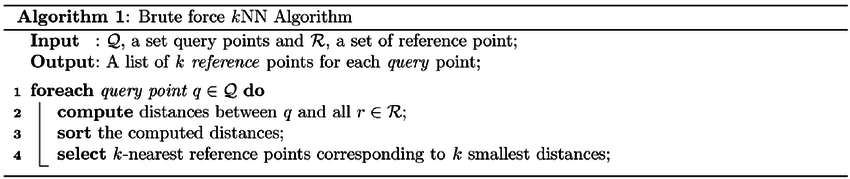


In [141]:
#Creating 2000 embbeding vector with len of 512
toy_embb=np.random.randn(2000,512)/np.sqrt(toy_embb**2).sum(1,keepdims=True) # L2 normalization 

#create query vector 
toy_q=np.random.randn(512)/np.sqrt(toy_q**2).sum(keepdims=True)  # L2 normalization  

dot_sim=toy_embb.dot(toy_q)


print(f"the q={toy_q[0:9]} is similar to  the first 5 element after sorting eq_distnace ={np.argsort(-dot_sim)[0:5]}")


the q=[ 0.08075982  1.48933064  0.64663809  0.20584974  1.56532669  0.44622845
  1.17802237 -0.54035256 -0.17783856] is similar to  the first 5 element after sorting eq_distnace =[1439 1299 1472 1340  135]
